# HousePrice-Prediction with Regression Techniques
## About
Data-Source: [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [1]:
# imports
import os
import pandas as pd
import numpy as np
import sklearn
%matplotlib inline
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew
sns.set()
import warnings
from sklearn.preprocessing import LabelEncoder
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

# load data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

First quick look on the data:

In [2]:
print("Size Training: %d, Size test: %d" %(len(train_df), len(test_df)))
#print(train_df.head(3))
print('SalePrice' in test_df.columns)

Size Training: 1460, Size test: 1459
False


## Data preparation
Before training and evaluating any model on the data, the datasets have to be prepared.

### Missing Values
First, the missing values should be eliminated. To do so, I will concatenate the training and test data first and remove/impute the missing values in the next steps.
Let's have a look at the missing values for each feature first. I will limit the analysis to all features where the ratio of nan-values is greater than 0.5%:
* **PoolQC**: Only 0.3% of the entries have a value for the pool quality. According to the description, NaN values is equal to 'no pool available' though and thus can be translated to this value.
* **MiscFeature**: Includes different values like Elevator, 2nd garage etc. that are not represented by a separate feature. Nan means there is no such special value at all. This feature could probably be transformed with OneHot-Encoding.
* **Alley/Fence/FireplaceQu/GarageFinish/GarageQual/GarageCond/GarageYrBlt/GarageType/BsmtCont/BsmtExposure/BsmtQual/BsmtFinType1/BsmtFinType2/MasVnrType/MasVnrArea**: Defines the type of this category. NaN means there isn't such an item at all, so the missing values can be translated to 'not available' or 'not applicable'.
* **LotFrontage**: The distance between the street and the house should be similar within the same neighborhood. Therefore I will calculate the median (mean is probably to sensitive for outliers here) and use it to fill the missing values.

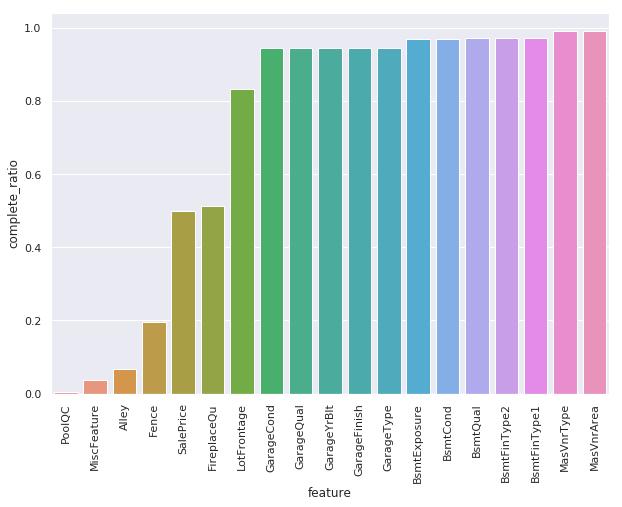

In [3]:
ntrain = len(train_df)
ntest = len(test_df)
complete_df = pd.concat([train_df, test_df]).reset_index(drop=True)
length_complete = len(complete_df)
sales_df = complete_df[['SalePrice', 'Id']]
# complete_df.drop('SalePrice', axis=1, inplace=True)

missing_df = pd.DataFrame(columns=['feature', 'complete_ratio'])
for feature in complete_df.columns:
    complete_ratio = len(complete_df[feature].dropna()) / length_complete
    missing_df.loc[len(missing_df) + 1] = [feature, complete_ratio]
 

f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='90')
rel_missing = missing_df[missing_df['complete_ratio'] <= 0.995].sort_values('complete_ratio', ascending=True)
sns.barplot(rel_missing['feature'], rel_missing['complete_ratio'])

As explained above, there exists a simple possibility to fill the missing values in most cases. This will be done for the features where the ratio of missing values is greater than 0.5%. After that, I decided to drop the remaining missing values since this reduces the size of the dataset only by 13 entries from 2919 to 2106.

In [4]:
# replace NaN by 'None' where applicable
none_columns = ['PoolQC', 'Alley', 'Fence', 'FireplaceQu', 'GarageCond', 'GarageQual', 'GarageYrBlt', 'GarageFinish',
               'GarageType', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'MiscFeature', 'MasVnrType']
complete_df_none = complete_df.copy()
for none_column in none_columns:
    complete_df_none[none_column] = complete_df_none[none_column].fillna('none')
    
# replace NaN by 0 where applicable
none_columns = ['BsmtFinType1', 'BsmtFinType2', 'MasVnrArea']
for none_column in none_columns:
    complete_df_none[none_column] = complete_df_none[none_column].fillna(0)
    
# Fill LotFrontage
neighboor_lf = complete_df_none.groupby('Neighborhood')['LotFrontage'].agg('median').reset_index()
neighboor_lf.columns = ['Neighborhood','median_dis']

def replace_na(r):
    neighborhood = r['Neighborhood']
    lf = r['LotFrontage']
    if pd.isnull(lf):
        return neighboor_lf[neighboor_lf['Neighborhood'] == neighborhood]['median_dis'].values[0]
    else:
        return lf

complete_df_none['LotFrontage'] = complete_df_none.apply(lambda x: replace_na(x), axis=1)

# one hot encoding for MiscFeature
print(set(complete_df_none['MiscFeature'].values))
complete_df_none = pd.concat([complete_df_none, pd.get_dummies(complete_df_none['MiscFeature'])], axis=1)
complete_df_none.drop('MiscFeature', axis=1)

# check ratio of nans again
missing_df2 = pd.DataFrame(columns=['feature', 'complete_ratio'])
for feature in complete_df_none.columns:
    complete_ratio = len(complete_df_none[feature].dropna()) / length_complete
    missing_df2.loc[len(missing_df2) + 1] = [feature, complete_ratio]
print(missing_df2[missing_df2['complete_ratio'] <= 0.995].sort_values('complete_ratio', ascending=True)) 

# drop remaining missing values
print(len(complete_df_none))
no_salesprice = [x for x in complete_df_none.columns if x != 'SalePrice']
print(len(complete_df_none.dropna(subset=no_salesprice)))
complete_df_none.dropna(subset=no_salesprice, inplace=True)

{'Gar2', 'Othr', 'none', 'TenC', 'Shed'}
      feature  complete_ratio
71  SalePrice        0.500171
2919
2906


### Feature Engineering


In [5]:
# some numerical values are actually categorical and have to be transformed
to_string_cols = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']
for col in to_string_cols:
    complete_df_none[col] = complete_df_none[col].astype(str)

Looking at the values of some discrete variables like *FireplaceQu* (Poor, Fair, Average, Good, Excellent), one can see that those values have an order. In order to use this information, the values are transformed with LabelEncoding. 

In [6]:
# some categorical values can be ordered
complete_df_order = complete_df_none.copy()
order_cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond',
              'HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence', 
              'BsmtExposure', 'GarageFinish', 'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'Alley', 
              'CentralAir', 'MSSubClass', 'OverallCond', 'YrSold', 'MoSold']

for col in order_cols:
    encoder = LabelEncoder()
    encoder.fit(list(complete_df_order[col].values))
    complete_df_order[col] = encoder.transform(list(complete_df_order[col].values))

I will add the sum of the following variables as an extra future, representing the total area of a house which should be pretty important when determining the salesprice: TotalBsmtSF, 1stFlrSF, 2ndFlrSF.

In [7]:
# add new feature: total area
complete_df_order['TotalSF'] = complete_df_order['TotalBsmtSF'] + complete_df_order['1stFlrSF'] + complete_df_order['2ndFlrSF']

Get dummy values for categorical features

In [8]:
complete_df_order = pd.get_dummies(complete_df_order)

The result table will be splitted back in test and training set and the target variable will be added to both.

In [9]:
# split train and test set again and add target values
print(len(complete_df_order))
complete_df_order['Id'] = pd.to_numeric(complete_df_order['Id'])
max_train = max(train_df['Id'])
train_df2 = complete_df_order[complete_df_order['Id'] <= max_train]
test_df2 = complete_df_order[complete_df_order['Id'] > max_train]

2906


### Target Variable

Interpreting and evaluating the model will be easier if the target variable is normally distributed. Thus I will check whether this is fulfilled by plotting its distribution and the QQ-Plot. Findings:
* The first plot shows that the data is right skewed
* The QQ-Plot confirms that the data is not normally distributed.

/home/dennis/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


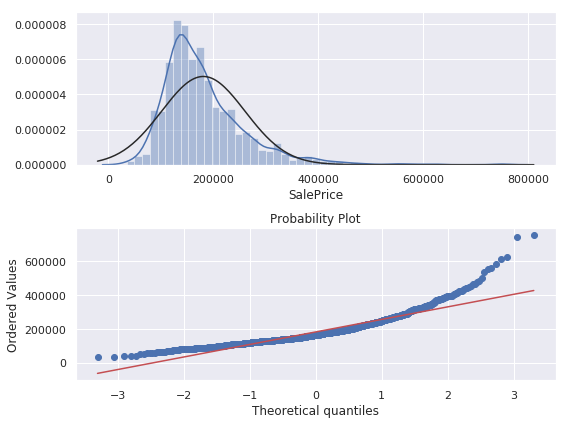

In [10]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

sns.distplot(train_df2['SalePrice'], fit=norm, ax=ax1)

res = stats.probplot(train_df2['SalePrice'], plot=ax2)
fig.tight_layout()
plt.show()

To solve this, I will apply the log-log-transformation on the target variable.
As a result, one can see that the distribution of the SalesPrices appears more normally distributed now. 

/home/dennis/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


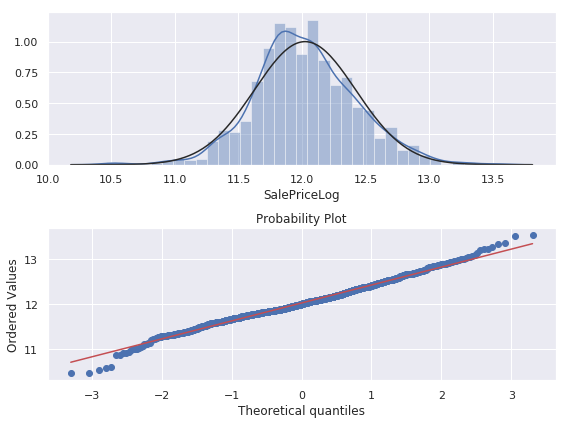

In [11]:
# use log to transform the dependent variable
train_df['SalePriceLog'] = np.log1p(train_df['SalePrice'])

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

sns.distplot(train_df['SalePriceLog'], fit=norm, ax=ax1)

res = stats.probplot(train_df['SalePriceLog'], plot=ax2)
fig.tight_layout()
plt.show()

## Modeling




In [26]:
# imports
from sklearn.linear_model import LogisticRegression, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

# data
test_df2.dropna(inplace=True)
y_true = test_df2['SalePrice']
y_train = train_df2['SalePrice']
x_train = train_df2.drop('SalePrice', axis=1)
x_test = test_df2.drop('SalePrice', axis=1)

# parameter for cross validation
k = 5

### Lasso Regression

In [27]:
lr = Lasso(alpha=0.005, random_state=1)
score = np.mean(cross_val_score(lr, x_train, y_train, cv=k))
print(score)

0.7901795173579136


### Elastic Net

In [ ]:
params = {'l1_ratio': [0.1, 0.3, 0.6, 0.9], 'alpha': [0.05, 0.005, 0.0005], 'random_state': [1]}
gs_en = GridSearchCV(ElasticNet(), params, cv=k)
gs_en.fit(x_train, y_train)
eNet = gs_en.estimator
score = np.mean(cross_val_score(eNet, x_train, y_train, cv=k))
print("Score: %s" %score)
print("Parameters: %s" % gs.best_params_)

0.8092397465951026
